# Proyecto 3 - Minería de datos
***Universidad del Valle de Guatemala***

___4 de marzo, 2025___

[link del reposiotio](https://github.com/DanielRasho/MD-Proyecto3)

**Autores:**
- Daniel Alfredo Rayo Roldán
- Gerardo Pineda
- Juan Luis

# Introducción
De acuerdo a *Herre, Samborska & Roser* (2025) varios medios parecen indicar que la cantidad de divorcios que ocurre cada año ha estado creciendo con los años, de hecho, según el Registro Nacional de Personas en Guatemala (2024) la cantidad de matrimonios disminuyeron y los divorcios aumentaron en 2024. Sin embargo se falla en realizar estos datos a nivel historico y entre diferentes países, dado que las variaciones son muy marcadas entre diferentes países, habiendo países cuya tasa de divorcios ha disminuido versus, otros que siguen en aument como paises bajos (Herre, Samborska & Rose, 2025). Este proyecto sera un intento en poder predecir que parejas se divorcian y las tendencias historicas en Guatemala.

# Situación Problemática

Durante la última década (2013–2023), se ha evidenciado una tendencia creciente en el número de divorcios registrados en Guatemala. Esta alza, especialmente notoria tras la disminución temporal en 2020 atribuida a la pandemia, ha generado inquietudes sobre los factores que impulsan la disolución de los matrimonios.

Diversos elementos sociodemográficos como la edad de los cónyuges, su nivel educativo, y las ocupaciones que desempeñan, parecen jugar un papel relevante en esta problemática. En particular, se ha observado que los matrimonios entre personas jóvenes podrían estar enfrentando mayores tasas de separación, lo cual sugiere una transformación en las dinámicas familiares y sociales del país.

Frente a esta realidad, se vuelve urgente estudiar estos patrones con un enfoque predictivo, de manera que se puedan anticipar tendencias futuras en el número de divorcios.

## Objetivos Generales

Usando los datos del INE (Instituto nacional de Guatemala) entre 2013 a 2020 sobre divorcios y matrimonios en Guatemala, se plantea: 

- Entrener un modelo que pueda predecir que parejas son propensas a divorciarse.
- Predecir la cantidad de divorcios futuros para los próximos 5 años.

## Objetivos Específicos
1. Determinar si el comportamiento de divorcios es creciente o decreciente.
2. Determinar cual fue el comportamiento de la cantidad de divorcios antes, durante y después de pandemia.
3. Predecir las carácteristicas socioeconómicas que tendrán los divorcios en los próximos 5 años.

In [71]:
import warnings
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from scipy.stats import shapiro, kstest
from sklearn.decomposition import PCA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Dont print warnings
warnings.simplefilter(action="ignore")

# Descripción de los datos
Se partieron de 2 sets de datos proporcionados por el INE (Instituto Nacional de Estadística) sobre matrimonios y divorcios ocurridos en Guatemala entre los años 2013 hasta 2023 (11 años) ambos contando con las mismas 19 variables. El set de divorcios comprende 76669 registros, la totalidad de los datos registrados por el INE. El set matrimonios comprende 76670, el cual es una muestra del set total, para tener un cantidad balanceada a los divorcios. **Se asumió que los todas las parejas en el conjunto de matrimonios se mantuvieron casadas durante el rango de tiempo estudiado,** es decir no hay parejas registradas en ambos datasets de matrimonios y divorcios.

Se necesitó hacer un procesamiento de los datos, dado que las disposición y nombre de las variables cambió ligeramente a lo largo de los años, diferencias que se unificaron en las siguientes variables finales, con las que se trabajó:

**Variables númericas:**

| Descripcion | Codificación | Categoría Nula |
|-----------------|-------|----|
| Edad del hombre | EDADHOM  | 999 |
| Edad de la mujer | EDADMUJ | 999 |

**Variables categóricas:**

| Descripcion | Codificación | Categoría Nula | 
|-----------------------------------|-------|---|
| Departamento de registro          | DEPREG | N/A |
| Municipio de registro             | MUPREG   |N/A | 
| Mes de registro                   | MESREG   |N/A |
| Año de registro                   | AÑOREG   |N/A |
| Día de ocurrencia                 | DIAOCU |N/A |
| Mes de ocurrencia                 | MESOCU  |N/A |
| Año de ocurrencia                 | AÑOOCU |N/A |
| Departamento de ocurrencia        | DEPOCU |N/A |
| Municipio de ocurrencia           |  MUPOCU |N/A |
| Grupo étnico del hombre           | PUEHOM | 9 |
| Grupo étnico de la mujer          | PUEMUJ | 9 |
| Nacionalidad del hombre           | NACHOM | 9999 | 
| Nacionalidad de la mujer          | NACMUJ | 9999 |
| Escolaridad del hombre            | ESCHOM | 9 | 
| Escolaridad de la mujer           | ESCMUJ | 9 |
| Ocupación del hombre              | CIUOHOM | 99 | 
| Ocupación de la mujer             | CIUOMUJ | 99 |

***Nota:*** *La "categoría nula" para las variables en las que aplica, indica ese valor reservado para observaciones "sin definir"; se podrían considerar comoun equivalente del Nan.*

***Nota:*** A partir de ahora los nombres de las variables en su versión codificada o extendida se usará indistintamente, dependiendo de cual ofrece una mayor claridad a la hora de presentar la información.

In [72]:
# Step 1: Get all CSV file paths
divorces_files = glob.glob("data/divorces/*.CSV")
marriage_files = glob.glob("data/marriages/*.csv")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

# Step 3: Merge without storing copies
divorces_df = pd.concat((read_and_clean(file) for file in divorces_files), ignore_index=True)
marriages_df = pd.concat((read_and_clean(file) for file in marriage_files), ignore_index=True)

In [73]:
# Now dictionary mappings are defined in extern script. Call the variables just as usual
%run ./dictionaries.py

<Figure size 640x480 with 0 Axes>

## Análisis de variables
Con la base de datos preparada, se procedio a inspeccionar las características y frencuencias de las diferentes variables con el fin de determinar si algunas podrian ser descartadas o simplificadas debido a la poca información que ofrecen.

Sin embargo, es primero importante describir la distribución de datos nulos en cada uno de las variables: 

**Datos nulos para datos de divorcios**

In [74]:
df_null_values = divorces_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(divorces_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
null_counts_df['Variable'] = null_counts_df['Variable'].map(VARS)
total_rows = len(divorces_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,Edad hombre,34573,45.1
1,Edad mujer,34521,45.0
2,Pueblo étnico del hombre,37606,49.0
3,Pueblo étnico de la mujer,37726,49.2
4,Nacionalidad hombre,298,0.4
5,Nacionalidad mujer,306,0.4
6,Escolaridad del hombre,33234,43.3
7,Escolaridad de la mujer,32856,42.9
8,Ocupación de la mujer,23712,30.9
9,Ocupación de la mujer,19831,25.9


**Datos nulos para datos de matrimonios**

In [75]:
df_null_values = marriages_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(marriages_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
null_counts_df['Variable'] = null_counts_df['Variable'].map(VARS)
total_rows = len(marriages_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,Edad hombre,13,0.0
1,Edad mujer,18,0.0
2,Pueblo étnico del hombre,5012,6.5
3,Pueblo étnico de la mujer,7076,9.2
4,Nacionalidad hombre,0,0.0
5,Nacionalidad mujer,2,0.0
6,Escolaridad del hombre,2907,3.8
7,Escolaridad de la mujer,4767,6.2
8,Ocupación de la mujer,1143,1.5
9,Ocupación de la mujer,742,1.0


Se puede observar que para los datos de divorcios todas las variables donde hay posibilidad de haber datos nulos, hay un porcentaje considerable siendo variables *Nacionalidad* (0.4%), y los mayores las variables de *Grupo étnico* (49.2%). Por el contrario el conjunto de datos de matrimonios contuvo porcentajes no mayores al 10% de datos nulos. A continuación se explica el tratamiento que se le dio a los valores nulos.

**Tratamiento de datos nulos**
Para los datos nulos, la primera opción fue crear un modelo que prediciera cuales podrían ser los valores nulos en base a los patrones que exciben las demás variables, sin embargo para ello fue primero necesario determinar que hubiera algún tipo de correlación entre las variables, para ello se elaboró las matrices de correlación siguientes.

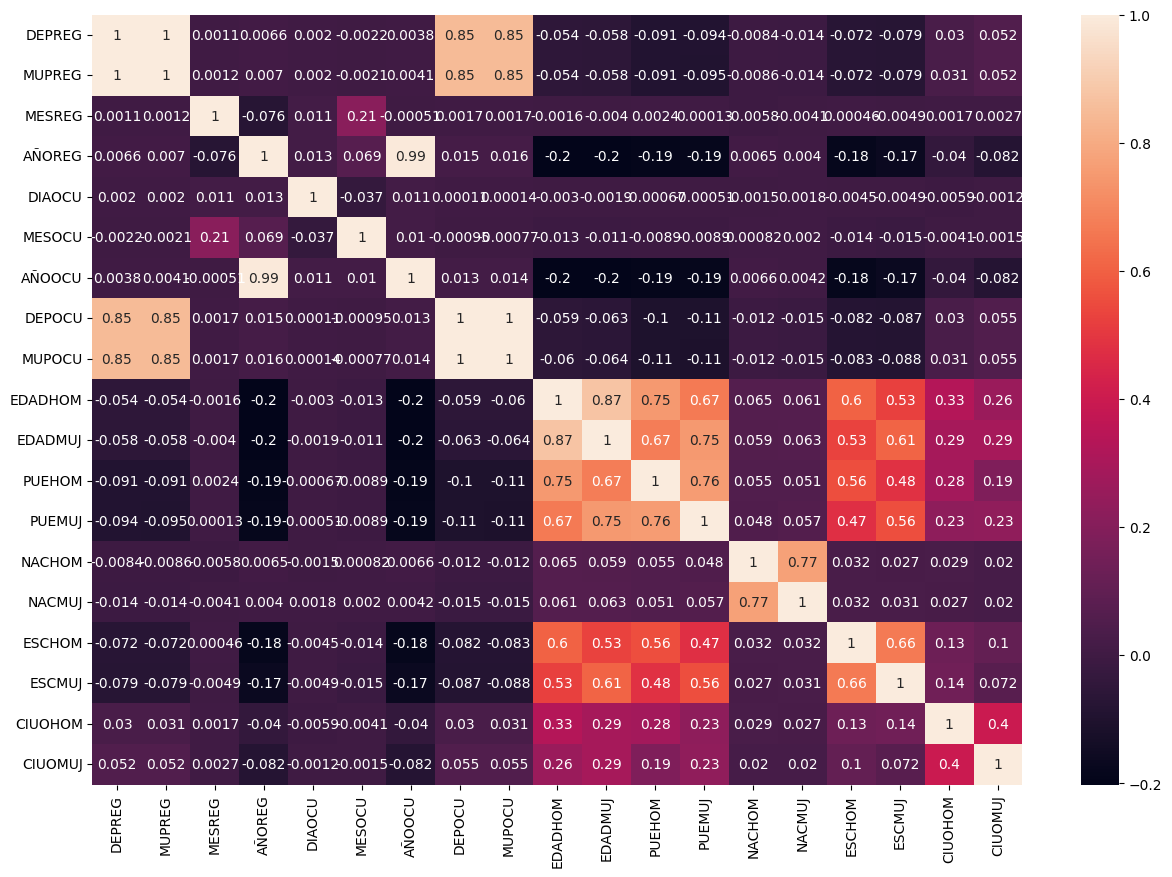

In [76]:
# 2. 
corr = divorces_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

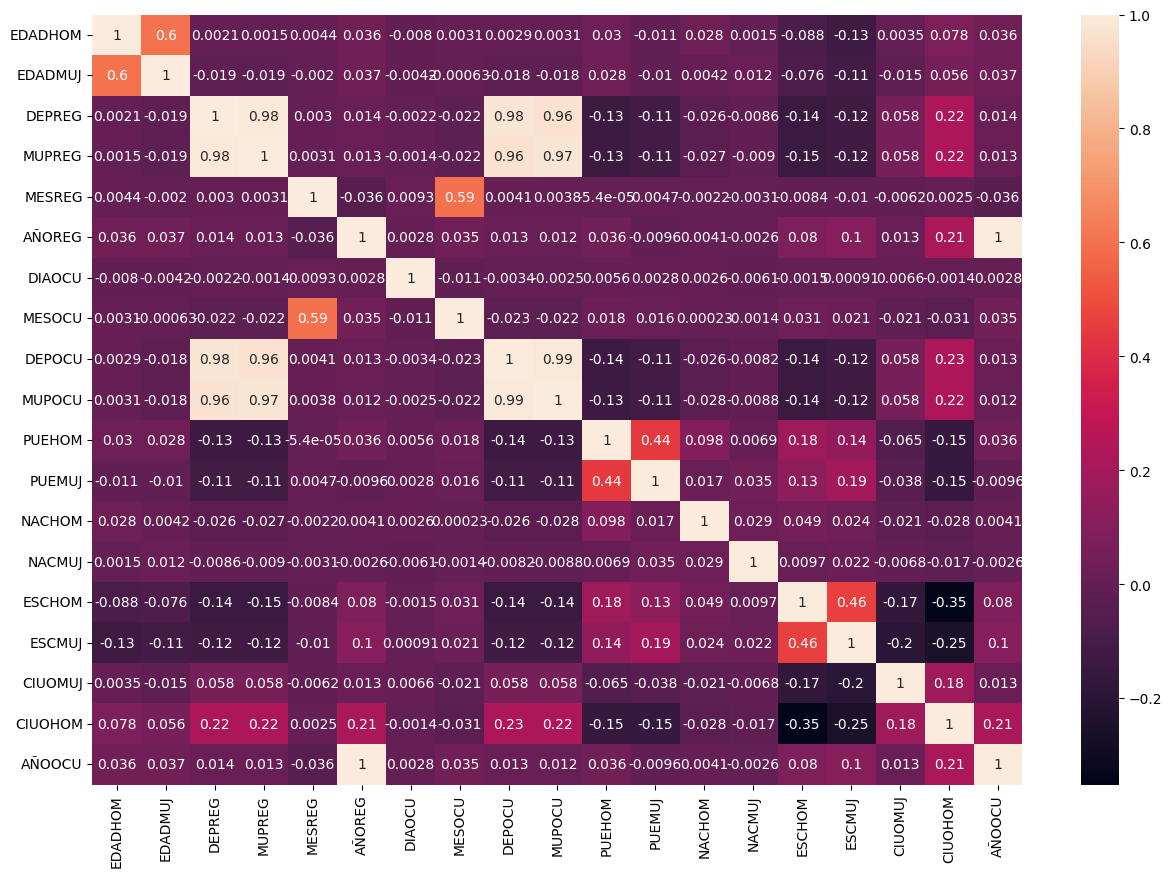

In [77]:
# 2. 
corr = marriages_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

Para el dataset de divorcios se pudo observar correlación entre grupos de variables, lo contrario se puede decir del set de matrimonios, que presenta baja correlación entre las variables. Dada la diferencia en la naturaleza de los datos, **los datos nulos serán tratados diferente para cada dataset**.

Para los matrimonios, al contar con bajo porcentaje de datos nulos, se vio razonable remplazarlos por los datos más comunes en el resto del dataset, sin que afectara grandemente la distribución de los datos. El mismo enfoque no se pudo aplicar a los divorcios, al ver que los datos nulos tomaban un espacio considerable, se estaría amplificando demasiado ciertas categorías. Así que se decidió seguir el plan original y crear modelos que predijeran los valores de los datos nulos.

Antes de hacer cualquier tratamiento, este es una ejemplo de como se miraba la distribución de las variables de edad sin ningún tratamiento, además de test de normalidad, en siguientes secciones se podrá ver la nueva distribución para estas mismas variables y se podrá verificar que tienen un forma parecida (con un sesgo izquierdo menos pronunciado) además que los test de normalidad siguieron dando las mismas conclusiones.

In [78]:
def normality_tests (merged_df):
# Create a dictionary to store the results
    results = {
        "Prueba": [],
        "Variable": [],
        "Estadística": [],
        "P-valor": [],
        "Distribución normal": []
    }

# EDADHOM variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADHOM'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADHOM'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADHOM")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# EDADMUJ variable
# Shapiro-Wilk test
    stat, p_value = shapiro(merged_df['EDADMUJ'])
    results["Prueba"].append("Shapiro-Wilk")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Kolmogorov-Smirnov test
    stat, p_value = kstest(merged_df['EDADMUJ'], 'norm')
    results["Prueba"].append("Kolmogorov-Smirnov")
    results["Variable"].append("EDADMUJ")
    results["Estadística"].append(stat)
    results["P-valor"].append(p_value)
    results["Distribución normal"].append("Probable" if p_value > 0.05 else "No probable")

# Convert the results to a pandas DataFrame
    return pd.DataFrame(results)

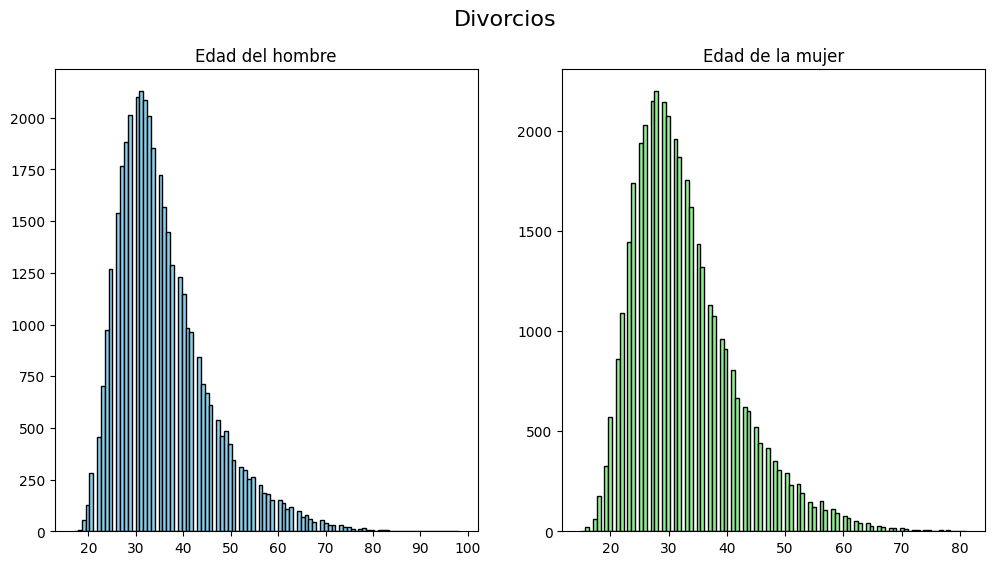

In [79]:
df_filtered = divorces_df[(divorces_df['EDADHOM'] != 999) & (divorces_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Divorcios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [80]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.642764,4.705670e-143,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.641962,4.011582e-143,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


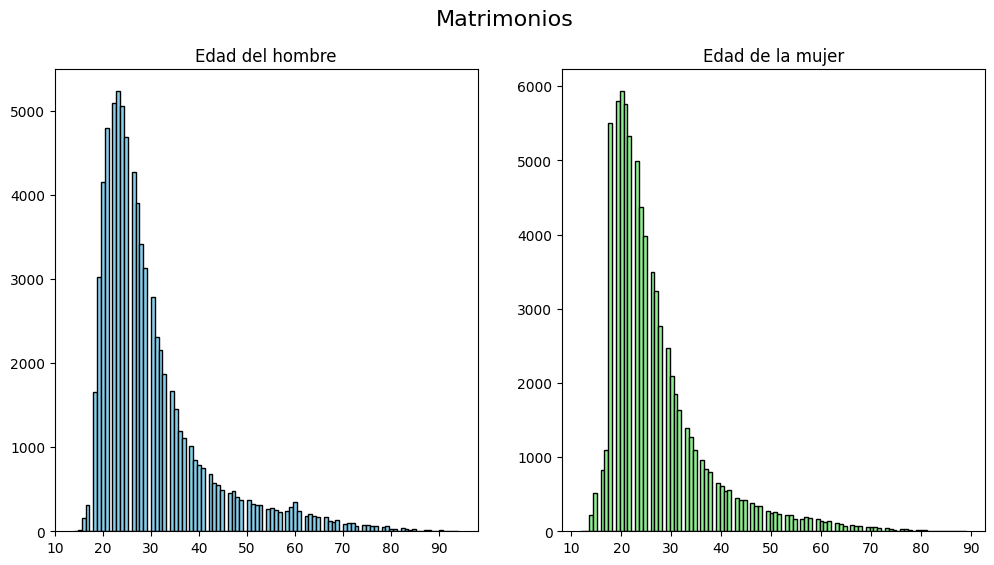

In [81]:
df_filtered = marriages_df[(marriages_df['EDADHOM'] != 999) & (marriages_df['EDADMUJ'] != 999)]

# Plotting histograms
plt.figure(figsize=(12, 6))

# General title
plt.suptitle('Matrimonios', fontsize=16)

# Plotting variable_1
plt.subplot(1, 2, 1)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Edad de la mujer')
%matplotlib inline

In [82]:
normality_tests(divorces_df)

,Prueba,Variable,Estadística,P-valor,Distribución normal
0,Shapiro-Wilk,EDADHOM,0.642764,4.705670e-143,No probable
1,Kolmogorov-Smirnov,EDADHOM,1.000000,0.000000e+00,No probable
2,Shapiro-Wilk,EDADMUJ,0.641962,4.011582e-143,No probable
3,Kolmogorov-Smirnov,EDADMUJ,1.000000,0.000000e+00,No probable


In [83]:
# THE FINAL DATAFRAME IS HERE -> total_df
divorces_df["ARE_MARRIAGED"] = 0
marriages_df["ARE_MARRIAGED"] = 1
total_df = pd.concat([divorces_df, marriages_df], ignore_index=True)
divorces_df.drop(columns="ARE_MARRIAGED", inplace=True)
marriages_df.drop(columns="ARE_MARRIAGED", inplace=True)